## Algorithms Assignment 1
- Subject code: `EC31205`
- Instructor: Debashis Sen
- Teaching assistant: Akshit Maurya

### Student details
- Name: Ashutosh Dayal
- Roll no.: **22EC30066**

### Requirements
- `numpy`
- `matplotlib`

**IMPORTANT**

Link to Google Colab notebook: https://colab.research.google.com/drive/15F7OsoaFBada7vnKLQC5uTPOM_PP6Smy?usp=sharing

- If running this notebook on your local system, please keep the resources (i.e. `00039_Semantic.png` and `00055_semantic.png`) in the same relative directory to this notebook.
- If running the Google Colab notebook, upload the files with the same filename on the temporary session storage.
- Also upload the `sample64.png`, it demonstrates the seperate instance of background case, in the last section of the notebook.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import cv2
from collections import deque

### Loading image
Please adjust the following paths according to your image location.

`IMAGE_PATH`: Original source of image (not necessary to change, not used in instance finding) </br>
`SRC`: Segmented image (**IMP**)

In [76]:
#IMAGE_PATH=r"00039.jpg"
SRC=r"00039_Semantic.png" #semantic segmented image

In [77]:
#orig_image = plt.imread(IMAGE_PATH)
img=plt.imread(SRC)[:,:,:3] #Drop the "alpha" channel, in case the input is in "*.png" format.

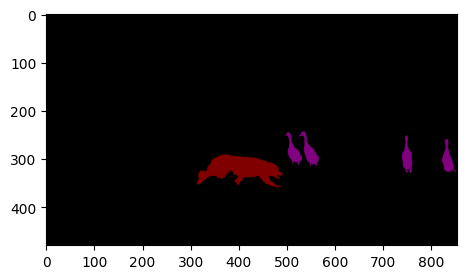

In [78]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 3]
#plt.subplot(1,2,1);
#plt.imshow(orig_image); 
plt.subplot(1,2,2);
plt.imshow(img);

In [79]:
(W, H, C) = img.shape
W, H, C

(480, 854, 3)

### Preprocessing
The averaging operation defined in the assignment in done as below.

In [80]:
img_avg=np.average(img,axis=2)
img_avg.shape #Dropped the channels by its mean

(480, 854)

*Note*:
Possible error in cell 51:
We are losing information when carrying out the average operation in cell `51`. Since two cells of different colors (i.e. RGB tuple) can have the same average. 
</br>Eg. `avg([A, B, C])` = `avg([B, C, A])` = `avg([C, B, A])` = .... (average is same for all permutations of A, B and C)

### Number of unique classes
The total number of unique classes that are present in the image is the unique colors present in `img`.</br>

In [81]:
num_classes=np.unique(img_avg).shape[0]-1
num_classes

2

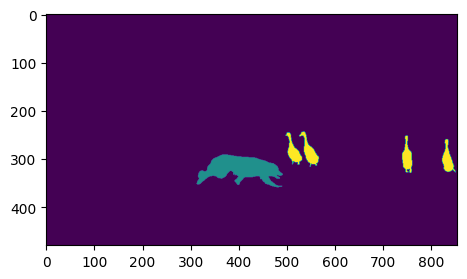

In [82]:
plt.imshow(img_avg);

In [83]:
classes = np.unique(img_avg)
classes

array([0.        , 0.16732027, 0.33464053], dtype=float32)

### Basic description of algorithm
- `Dx` and `Dy` is used to access the neighbours of (`i`, `j`) of the image. For all (`dx`, `dy`) corresponding to same index element in `Dx` and `Dy` respectively,  (`i`+`dx`, `j`+`dy`) is considered a neighbour of (`i`, `j`) in the graph, if color of the nodes (i.e. image pixels) are same.
- `vis` array is maintained to avoid repeatitive exploration (standard BFS).
- `dis` array is maintained to get the shortest distances in the graph (not used here).

Time complexity: *O(`n`.`m`)*</br>
Space complexity: *O(`n`.`m`)*</br>
where `n` and `m` are heights and widths for the `img` respectively.

## Constrains
- No of states: `8`.`n`.`m`
- Constrains of the problem should be `W`.`H` <= 1e6 for proper working

In [84]:
Dx=[0, 0, 1, -1, 1, -1, 1, -1] #Corresponding indices of 8 neighbours
Dy=[1, -1, 0, 0, 1, -1, -1, 1]

"""
Parameters
-----------
`img`: Input image `np.array` of dimensions (W, H, C) where `W` and `H` are dimensions of the image, and `C` are the channels. This functions expects the `img` to have 3 channels of the form `RGB`.
averaging: Boolean denoting whether to perform the averaging operation of the image

`averaging`: Whether to perform the averaging option on the image.

`detect_background`: If set to `True`, detected the background as objects, and seperated background (through other objects will be reported as different instances of the background).

Returns
----------
[instance_seg, labels, instances_count] 
`instance_seg`: Represents the instance segmented output 
`labels`: Mapping of orignal semantic segmented value with instance ids
`instances_count`: Total number of instances (components) in `img`
"""
def comp_find(img, averaging=True, detect_background=True): #O(nm)
    if (averaging): img=np.average(img,axis=2)
    [n, m] = img.shape
    curr_id=1 
    vis=np.zeros_like(img, dtype=np.bool_)
    dis=np.full_like(img, 1e7, dtype=np.int64)
    instance_seg=np.zeros_like(img, dtype=np.uint8)

    classes= np.unique(img)
    labels={cl:[] for cl in classes}

    def bfs(i, j):
        qu=deque() #BFS queue
        dis[i][j]=0
        qu.append(np.array([i,j]))
        while len(qu):
            ti,tj=qu[0]
            qu.popleft()

            if vis[ti][tj]: continue; #Avoid revisit
            else: vis[ti][tj]=1

            instance_seg[ti][tj]=curr_id
            for (dx,dy) in zip(Dx,Dy):
                (nx,ny)=(ti+dx, tj+dy)
                if 0<=nx<n and 0<=ny<m and img[ti][tj]==img[nx][ny] and dis[nx][ny]>dis[ti][tj]+1: #Relax the edge, if lesser distance possible
                    dis[nx][ny]=dis[ti][tj]+1
                    qu.append(np.array([nx,ny]))
        
    for i in range(n):
        for j in range(m):
            if (vis[i][j]==0 and (detect_background or img[i][j]!=0)): #Ignores background, since it's not counted as an object.
                bfs(i,j)
                labels[img[i][j]].append(curr_id)
                curr_id+=1

                if curr_id>10:
                    break
    return instance_seg, labels, curr_id-1

In [85]:
[out, labels, instances_count]=comp_find(img)

In [86]:
instances_count

6

### Original semantic segmentation

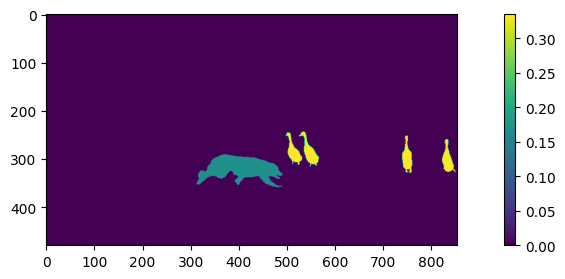

In [87]:
__=np.average(img[:,:,:3],axis=2)
_=plt.imshow(__)
plt.colorbar(_)

In [88]:
print("Classes:", np.unique(__))

Classes: [0.         0.16732027 0.33464053]


### Instance segmentation mask
Following output represents the image and each instance is associated with an `id`, which can be seen on the colorbar.

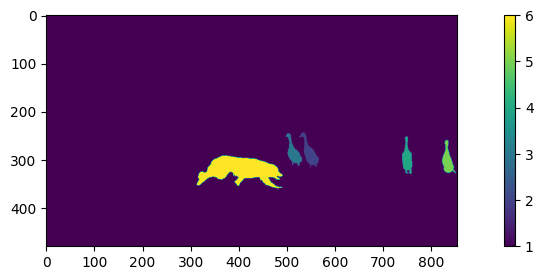

In [89]:
_=plt.imshow(out)
plt.colorbar(_)

The association of instance id with orignal semantic segmentation color is given by the `labels`.</br>
- `key`: Orignal color of the semantic class (after averaging out)</br>
- `value`: Instance id associated with the semantic class


In [90]:
for (a,b) in zip(range(len(labels)),labels.values()):
    print("Class", a, ":",b)

Class 0 : [1]
Class 1 : [6]
Class 2 : [2, 3, 4, 5]


`Class 0` corresponds to the background, if there are multiple instances of background and `detect_background` is set to `True` in the `comp_find(.)` then the backgrounds are detected as seperate components and printed in the `Class 0` list.

### Saving the output
Used the function given in `Example_Code.ipynb` file to save the output in desired format.

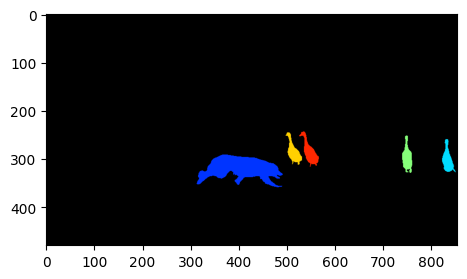

In [91]:
# This is a helpful
def color_and_save_map(instance_map=None,
                       file_name = "Instance_map.png"):
    """Relabels a instance map from 0 to unique labels.

    Args:
    instance_map: A 2-D NumPy array representing the instance map.

    Returns:
    A 3D NumPy array of shape [H,W,C] representing the RGB relabeled instance map.
    """
    assert instance_map.ndim == 2, "Instance map must be a 2-D array."
    assert instance_map.dtype == np.uint8, "Instance map must be a 8-bit unsigned integer array."

    # Create a dictionary to map old labels to new labels
    label_map = {}
    new_label = 0


    # Get unique labels and store it in array unique_labels
    unique_labels = np.sort(np.unique(instance_map))

    total_labels = len(unique_labels)

    # Iterate through the unique labels and re-map them to range 0,1,2...,total_labels-1
    for i in range(total_labels):
        label = unique_labels[i]
        if label not in label_map:
            label_map[label] = i

    # Relabel the semantic map using the created dictionary
    relabeled_map = np.vectorize(lambda x: label_map[x])(instance_map)

    # relabeled_map = np.stack((relabeled_map, relabeled_map, relabeled_map), axis=2)

    relabeled_map = relabeled_map*(255//len(unique_labels))

    relabeled_map = relabeled_map.astype(instance_map.dtype)

    # Convert relabeled map to RGB colored Image
    relabeled_map_color = cv2.applyColorMap(relabeled_map.reshape((relabeled_map.shape[0], relabeled_map.shape[1], 1)),
                                            cv2.COLORMAP_JET).astype(np.uint8)

    # Set label 0 to [0,0,0] color
    relabeled_map_color[relabeled_map==0,:] = 0

    #save image
    cv2.imwrite(file_name , relabeled_map_color)
    return relabeled_map_color

plt.imshow(color_and_save_map(out, "output1.png"))

### Test on "00055_semantic.png"

In [92]:
IMG_2_SRC="00055_semantic.png"

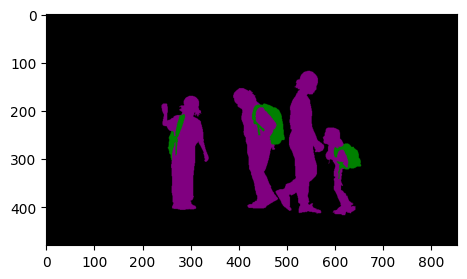

In [93]:
img2=plt.imread(IMG_2_SRC)[:,:,:3];
plt.imshow(img2)

In [94]:
[out, labels, instances_count]=comp_find(img2)

In [95]:
instances_count

10

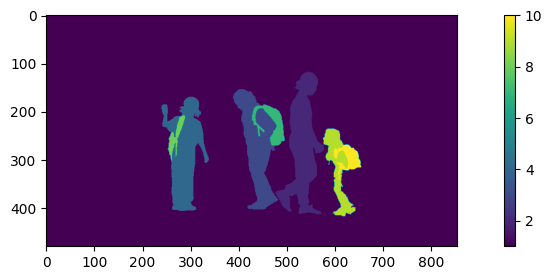

In [96]:
_=plt.imshow(out)
plt.colorbar(_)

In [97]:
for (a,b) in zip(range(len(labels)),labels.values()):
    print("Class", a, ":",b)

Class 0 : [1]
Class 1 : [5, 6, 7, 8, 10]
Class 2 : [2, 3, 4, 9]


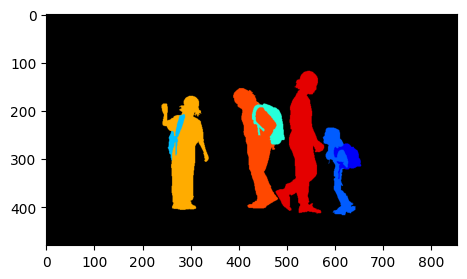

In [98]:
plt.imshow(color_and_save_map(out, "output2.png"))

### Seperate background test

In [99]:
IMG_3_SRC="sample64.png" #Please check this source attached in the google classroom submission

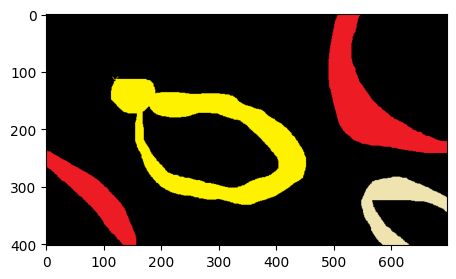

In [100]:
img3=plt.imread(IMG_3_SRC)[:,:,:3];
plt.imshow(img3)

In [101]:
[out, labels, instances_count]=comp_find(img3, detect_background=True)

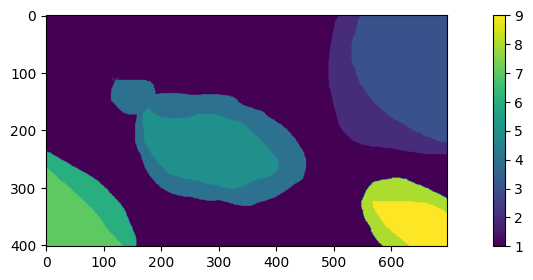

In [102]:
_=plt.imshow(out)
plt.colorbar(_)

In [103]:
for (a,b) in zip(range(len(labels)),labels.values()):
    print("Class", a, ":",b)

Class 0 : [1, 3, 5, 7, 9]
Class 1 : [2, 6]
Class 2 : [4]
Class 3 : [8]


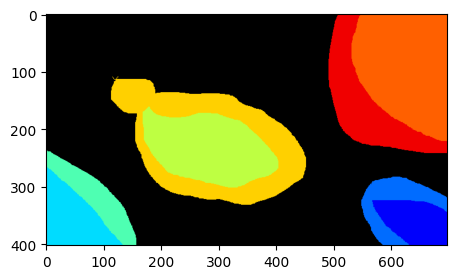

In [104]:
plt.imshow(color_and_save_map(out, "output3.png"))

### Potential improvements
- `Cell 6`: Averaging operation limits the scope of instance segmentation, since multiple classes may be associated with the same node in the graph. To avoid this we can simply, remove this operation, and same code can be used for proper output.
- UnionFind (Disjoint Set Union) DSU structures can also be used for the purpose, which are more suited for component finding tasks.
- The main algorithm runs with the time complexity of `O(n.m)` which is the best possible theoritical complexity.